In [1]:
import sys, os
import sparse
import xsimlab as xs
import xarray as xr
import numpy as np
import pandas as pd
import igraph as ig
from pgljupyter import SceneWidget

In [2]:
sys.path.insert(0, os.path.join(os.getcwd(), '..'))
import vmlab
from vmlab.models.vmango import vmango as model
from vmlab.enums import Nature, Position

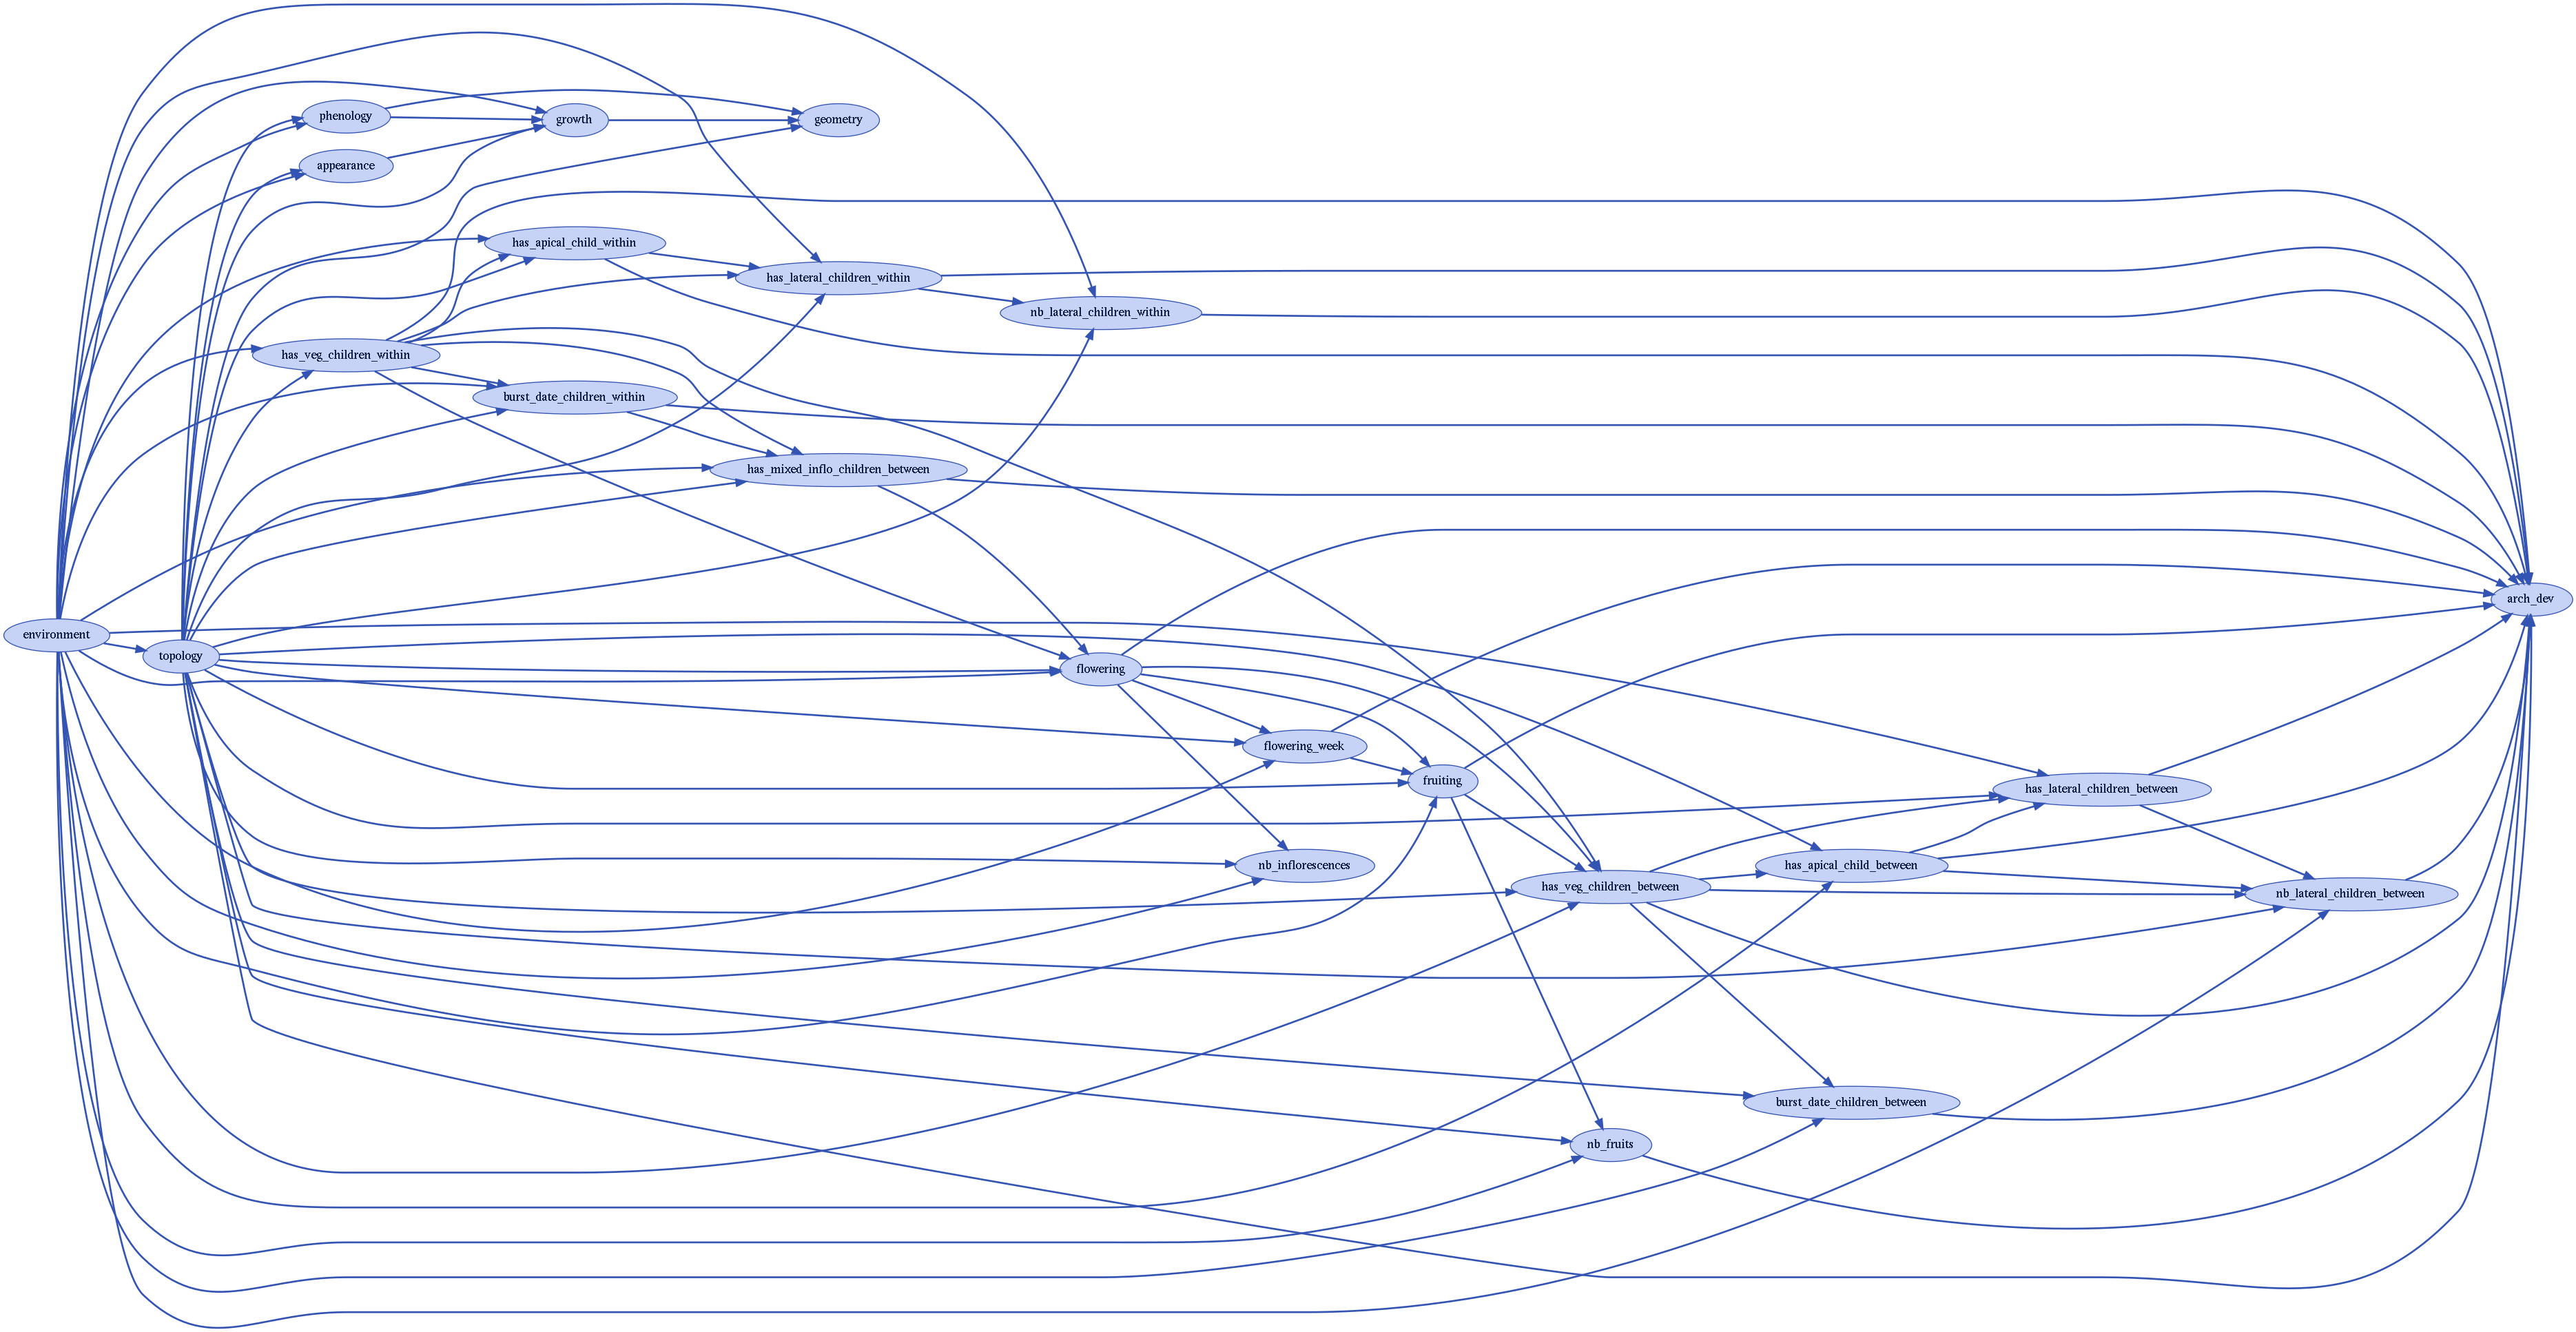

In [3]:
model.visualize()

In [4]:
nb_gus = 8
g = ig.Graph.Tree(nb_gus, 7, mode=ig.TREE_OUT)
adjacency = np.array(g.get_adjacency().data)

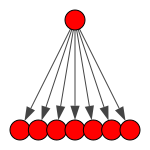

In [5]:
ig.plot(g, bbox=(0,0,150,150), layout=g.layout_reingold_tilford())

In [6]:
final_length_internodes = np.array([None] * nb_gus, dtype=object)
final_length_leaves = np.array([None] * nb_gus, dtype=object)
final_length_internodes[0] = [50]
final_length_leaves[0] = [0]
for i in range(1, nb_gus):
    final_length_internodes[i] = [40]
    final_length_leaves[i] = [0]

ds = vmlab.create_setup(
    model=model,
    setup_toml='../share/setup/vmango.toml',
    clocks={
        'day': pd.date_range(start='2002-04-01', end='2006-12-31', freq="1d")
    },
    main_clock='day',
    input_vars={
        'topology': {
            'current_cycle': 3,
            'month_begin_veg_cycle': 7,
            'doy_begin_flowering': 214,
            'adjacency': adjacency,
            'position': np.array([Position.APICAL] + ([Position.LATERAL] * (nb_gus - 2)) + [Position.APICAL])
        },
        'geometry': {
            'sampling_rate': -1
        },
        'phenology': {
            'bloom_date': np.full(nb_gus, '2002-11-01')
        },
        'arch_dev': {
            'burst_date': np.append(np.array(['2002-03-01'], dtype='datetime64[D]'), pd.date_range(start='2002-04-02', end='2002-04-30', periods=nb_gus-1).to_numpy()),
            'has_apical_child': np.ones(nb_gus),
            'nb_lateral_children': np.array([nb_gus - 1] + [4] * (nb_gus -1)),
            'nature': np.full(nb_gus, Nature.VEGETATIVE)
        },
        'appearance': {
            'final_length_internodes': final_length_internodes,
            'nb_internode': np.ones(nb_gus),
            'nb_leaf': np.zeros(nb_gus),
            'final_length_gu': np.full(nb_gus, 10),
            'final_length_leaves': final_length_leaves,
            'final_length_inflos': np.full(nb_gus, None, dtype=object)
        },
        'flowering_week': {
            'flowering_date': np.full(nb_gus, np.datetime64('NAT'), dtype='datetime64[D]')
        },
        'nb_inflorescences': {
            'nb_inflorescences': np.zeros(nb_gus)
        }
    },
    output_vars=None
)

In [7]:
sw = SceneWidget(size_world=2.5)
sw

SceneWidget(scenes=[{'id': 'LJTSszMh6a0kvyKZqPG3EQjTB', 'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x020\…

In [8]:
scene_ = None
@xs.runtime_hook(stage='run_step')
def hook(model, context, state):
    global scene_
    scene = state[('geometry', 'scene')]
    if scene != scene_:
        sw.set_scenes([scene], scales=[1/100])
        scene_ = scene
    
ds_out = ds.xsimlab.run(model=model, decoding={ 'mask_and_scale': False }, hooks=[xs.monitoring.ProgressBar(), hook])
ds_out

             0% | initialize 

<xarray.Dataset>
Dimensions:                                                             (GU: 780, day: 1736, hour: 24)
Coordinates:
  * GU                                                                  (GU) <U10 ...
  * day                                                                 (day) datetime64[ns] ...
  * hour                                                                (hour) int8 ...
Data variables:
    appearance__appeared                                                (GU) float64 ...
    appearance__final_length_gu                                         (GU) int64 ...
    appearance__final_length_inflos                                     (GU) object ...
    appearance__final_length_internodes                                 (GU) object ...
    appearance__final_length_leaves                                     (GU) object ...
    appearance__nb_internode                                            (GU) float64 ...
    appearance__nb_leaf                                                 (GU) float64 ...
    appearance__parameter_file_path                                     <U40 ...
    arch_dev__burst_date                                                (GU) datetime64[D] ...
    arch_dev__has_apical_child                                          (GU) float64 ...
    arch_dev__nature                                                    (GU) float64 ...
    arch_dev__nb_lateral_children                                       (GU) int64 ...
    burst_date_children_between__burst_date_children_between            (GU) datetime64[D] ...
    burst_date_children_between__table_dir_path                         <U80 ...
    burst_date_children_within__burst_date_children_within              (GU) datetime64[D] ...
    burst_date_children_within__burst_month_within                      (GU) int64 ...
    burst_date_children_within__table_dir_path                          <U79 ...
    environment__GR                                                     (hour) float64 ...
    environment__RH                                                     (hour) float64 ...
    environment__TM                                                     float64 ...
    environment__TM_air                                                 (hour) float64 ...
    environment__T_air                                                  (hour) float64 ...
    environment__T_fruit                                                (hour) float64 ...
    environment__parameter_file_path                                    <U52 ...
    flowering__flowering                                                (GU) float64 ...
    flowering__table_dir_path                                           <U62 ...
    flowering_week__flowering_date                                      (GU) datetime64[D] ...
    flowering_week__flowering_week                                      (GU) float64 ...
    flowering_week__table_dir_path                                      <U67 ...
    fruiting__fruiting                                                  (GU) float64 ...
    fruiting__table_dir_path                                            <U61 ...
    geometry__sampling_rate                                             int64 -1
    growth__length_gu                                                   (GU) int64 ...
    growth__length_inflos                                               (GU) object ...
    growth__length_leaves                                               (GU) object ...
    growth__parameter_file_path                                         <U40 ...
    growth__radius_gu                                                   (GU) float64 ...
    growth__radius_inflo                                                (GU) float64 ...
    has_apical_child_between__has_apical_child_between                  (GU) float64 ...
    has_apical_child_between__table_dir_path                            <U77 ...
    has_apical_child_within__has_apical_child_within                    (GU) float64

<AxesSubplot:xlabel='topology__appearance_date'>

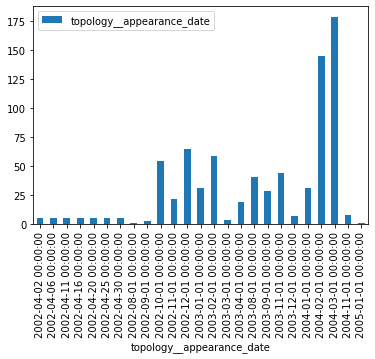

In [9]:
appearance_date = ds_out.topology__appearance_date.groupby(ds_out.topology__appearance_date)
appearance_date.count().to_dataframe().plot.bar()

<AxesSubplot:xlabel='flowering_week__flowering_date'>

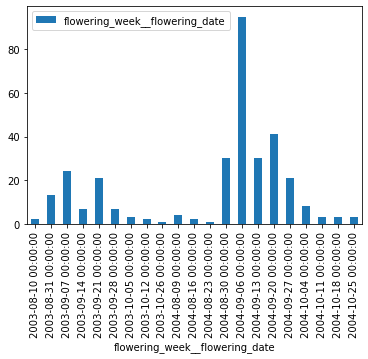

In [10]:
flowering_date = ds_out.flowering_week__flowering_date.groupby(ds_out.flowering_week__flowering_date)
flowering_date.count().to_dataframe().plot.bar()

<AxesSubplot:xlabel='topology__nb_inflo'>

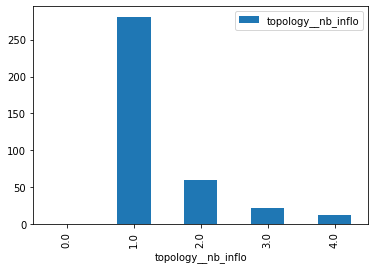

In [11]:
topology__nb_inflo = ds_out.topology__nb_inflo.groupby(ds_out.topology__nb_inflo)
topology__nb_inflo.sum().to_dataframe().plot.bar()

<AxesSubplot:xlabel='nb_fruits__nb_fruits'>

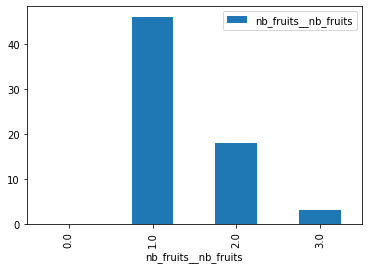

In [12]:
nb_fruits__nb_fruits = ds_out.nb_fruits__nb_fruits.groupby(ds_out.nb_fruits__nb_fruits)
nb_fruits__nb_fruits.sum().to_dataframe().plot.bar()

<AxesSubplot:xlabel='nb_children'>

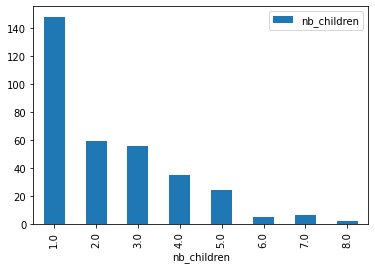

In [13]:
nb_children = xr.DataArray(ds_out.arch_dev__has_apical_child + ds_out.arch_dev__nb_lateral_children, name='nb_children')
nb_children = nb_children[nb_children > 0]
nb_children.groupby(nb_children).count().to_dataframe().plot.bar()

<AxesSubplot:xlabel='arch_dev__has_apical_child'>

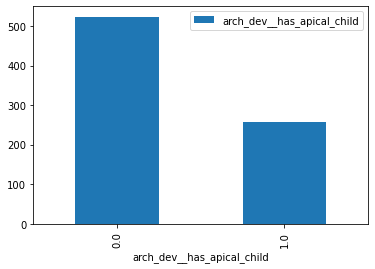

In [14]:
has_apical_child = ds_out.arch_dev__has_apical_child.groupby(ds_out.arch_dev__has_apical_child)
has_apical_child.count().to_dataframe().plot.bar()

In [15]:
nb_children = xr.DataArray(ds_out.arch_dev__has_apical_child + ds_out.arch_dev__nb_lateral_children, name='nb_children')
ds_children = xr.Dataset({
    'nb_children':  nb_children[nb_children > 0], 
    'cycle': ds_out.topology__cycle[nb_children > 0]
})
ds_children

<xarray.Dataset>
Dimensions:      (GU: 335)
Coordinates:
  * GU           (GU) <U10 'GU0' 'GU1' 'GU2' 'GU3' ... 'GU515' 'GU520' 'GU546'
Data variables:
    nb_children  (GU) float64 8.0 5.0 5.0 5.0 5.0 5.0 ... 3.0 1.0 1.0 1.0 1.0
    cycle        (GU) float64 3.0 3.0 3.0 3.0 3.0 3.0 ... 5.0 5.0 5.0 5.0 5.0

<AxesSubplot:xlabel='cycle'>

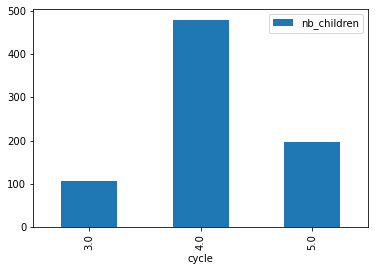

In [16]:
ds_children.groupby(ds_children.cycle).sum().to_dataframe().plot.bar()